# Segmentation task using U-Net
Version of the scientific paper:   
O. Ronneberger and P.Fischer and T. Brox, 2015, U-Net: Convolutional Networks for Biomedical Image Segmentation, Medical Image Computing and Computer-Assisted Intervention (MICCAI). 

**Our goal is to segment the food elements in the images from the Tray Dataset.**  

In [1]:
import torch
import torch.nn as nn
import torchmetrics as met
import torchvision.transforms.functional as functional

import pickle as pkl
import numpy as np

## Data

The data come from the Tray Dataset available on Kaggle. **PUT REFERENCES**  
Statistical analysis on the train subset.   

During our analysis of the images we find out that the intensity of the pixels isn't following a normal distribution and has a very long "tail" in each channel. However, the distribution seems similar for each channels. This might be a problem for the segmentation task of the pixels. We'll have to preprocess the images with appropriate transformations to overcome this.

As we can see from the various plot, the frequency of labels in images varies very much. Even some classes aren't represetend at all in the train dataset: straw, beef, meetball, ... Those classes have to be removed from the dataset in order to save up the compute ressources and considering the **no-free lunch theorem (give the reference here)**.  
For the other classes, we observe that the repartition of the first three classes (backgroung, tray, clutlery) is homogeneous but they are far more represented in the dataset's labels than any other one. Moreover, some other classes are absent from some images and present a normal distribution of the number of pixels in the rest.    
This may cause a problem when using the cross entropy loss function. **tell mathematically why here**.   
  
From our analysis, we'll delete the following classes from our considerations: from, straw, meatball, beef, carot, celery, water.   
Moreover, to facilitate the problem, we'll try to predict the first 3 classes to start: background, tray, cutlery. The strategy we'd like to apply is to determine the frequency by considering only those three and maybe apply weights on the loss to correct the unbalanced representation.  

One of the problems we have to deal with is by which class the rest of the set of the class should be replace?
Because the sum of all of the pixels labelled with one of the rest of the classes represents a fraction of almost 10% of the total of pixels, we'll create a class tagged as 'undetermined'.  



In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
import random

In [3]:
class MaskPILToTensor:
    """
        Class to transform Masks (targets) into a Tensor without the unwanted scaling of ToTensor
    """
    def __call__(self, img):
        img = functional.pil_to_tensor(img)
        return img

In [4]:
class TrayDataset(Dataset):

    def __init__(self, annotations_file_path, _img_dir_path, _label_dir_path,
                 scal_norm_transform=None, random_rot_transform=None, mask_transform=None,
                 data_augmentation=False):
        super(TrayDataset, self).__init__()
        self.labels               = pd.read_csv(annotations_file_path)
        self.img_dir_path         = _img_dir_path
        self.label_dir_path       = _label_dir_path
        self.scal_norm_transform  = scal_norm_transform
        self.random_rot_transform = random_rot_transform
        self.mask_transform       = mask_transform
        self.data_augmentation    = data_augmentation

        self.img_filenames   = sorted(os.listdir(self.img_dir_path))
        self.label_filenames = sorted(os.listdir(self.label_dir_path))

    def __len__(self):
        return len(os.listdir(self.img_dir_path))
    
    # function to modify the classes -> must be private and use in the init
    # and to modify the mask

    def transform_fn(self, image, label):
        """
            Transforms pipeline
        """
        # data augmentation
        if self.data_augmentation:
            # horizontal flipping
            if random.random() > 0.5:
                image = transforms.hflip(image)
                label = transforms.hflip(label)
            # vertical flipping
            if random.random() > 0.5:
                image = transforms.vflip(image)
                label = transforms.vflip(label)

        # random rotation (concatenation in order to obtain the same rotation)
        # at this point image and label are still in (height, width, channel) layout
        if self.random_rot_transform is not None:
            concat_img_label   = torch.cat((image, label), 0)
            transformed_concat = transforms.RandomRotation(10)(concat_img_label)

            image = transformed_concat[0]
            label = transformed_concat[1]

        # scal and normalization
        if self.scal_norm_transform is not None:
            image = self.scal_norm_transform(image)

        if self.mask_transform is not None:
            label = self.mask_transform(label)

        return image, label

    def __getitem__(self, img_idx):
        img_name   = self.img_filenames[img_idx]
        label_name = self.label_filenames[img_idx]

        image_path = os.path.join(self.img_dir_path, img_name)
        image      = Image.open(image_path)
        label_path = os.path.join(self.label_dir_path, label_name)
        label      = Image.open(label_path)
        
        image, label = self.transform_fn(image, label)

        return image, label

In [5]:
annotations_file_path    = '/home/dldou/Projets_ML/Unet/classes.csv'
train_dataset_img_path   = '/home/dldou/Projets_ML/Unet/TrayDataset/TrayDataset/XTrain/'
train_dataset_label_path = '/home/dldou/Projets_ML/Unet/TrayDataset/TrayDataset/yTrain/'

train_dataset            = TrayDataset(annotations_file_path, 
                                       train_dataset_img_path, train_dataset_label_path
                                       )

classes = pd.read_csv(annotations_file_path)
print(classes.head())
print("Number of classes:", len(classes))

   _id      _class       _name
0    0  background  background
1    1        tray        tray
2    2     cutlery     cutlery
3    3        form        form
4    4       straw       straw
Number of classes: 43


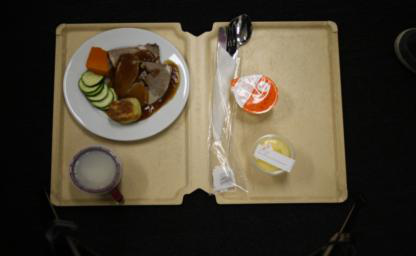

In [6]:
# images
train_dataset[0][0]

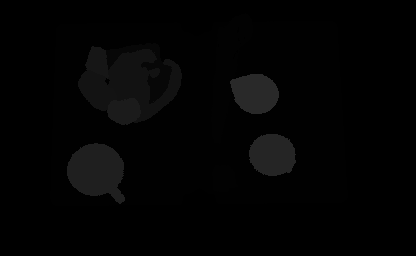

In [7]:
# labels
train_dataset[0][1]

In [8]:
def dump_dataset_in_pickle(dataset, save_path):
    images = []
    labels = []
    for image, label in dataset:
        images.append(np.array(image))
        labels.append(np.array(label))
    images_path = save_path + 'images.pkl'
    labels_path = save_path + 'labels.pkl'
    with open(images_path, "wb") as images_file, open(labels_path, "wb") as labels_file:
        pkl.dump(images, images_file)
        pkl.dump(labels, labels_file)


def get_stats_on_raw_numpy_data(images_pkl_path, labels_pkl_path, classes):
    """
        Function that regroups the statistics and various plots necessary to uexplore the properties of the dataset
    """
    
    with open(images_pkl_path, 'rb') as images_file, open(labels_pkl_path, "rb") as labels_file:
        images = pkl.load(images_file)
        labels = pkl.load(labels_file)

    print("\nTrain dataset information\n")
    print(f"Number of images:\t{len(images)}")
    print(f"Images' shape:\t\t{images[0].shape}")
    print(f"Images' dytpe:\t\t{images[0].dtype}")
    print(f"Labels' shape:\t\t{labels[0].shape}")
    print(f"Labels' dytpe:\t\t{labels[0].dtype}")
    print(f"Number of classes:\t{len(classes)}")


    imgs_array = np.array(images)

    # compute mean values of images for each channel    
    mean_images_red = np.mean(imgs_array[:,:,:,0]) 
    mean_images_green = np.mean(imgs_array[:,:,1]) 
    mean_images_blue = np.mean(imgs_array[:,:,2]) 
    print(f"Mean of RGB values:\tred = {mean_images_red:.1f}, green = {mean_images_green:.1f}, blue = {mean_images_blue:.1f}")

    median_images_red = np.median(imgs_array[:,:,0]) 
    median_images_green = np.median(imgs_array[:,:,1]) 
    median_images_blue = np.median(imgs_array[:,:,2]) 
    print(f"Median of RGB values:\tred = {median_images_red:.1f}, green = {median_images_green:.1f}, blue = {median_images_blue:.1f}")

    # min = 0 --> black
    min_images_red = np.min(imgs_array[:,:,:,0]) 
    min_images_green = np.min(imgs_array[:,:,1]) 
    min_images_blue = np.min(imgs_array[:,:,2]) 
    print(f"Min of RGB values:\tred = {min_images_red:.1f}, green = {min_images_green:.1f}, blue = {min_images_blue:.1f}")

    max_images_red = np.max(imgs_array[:,:,:,0]) 
    max_images_green = np.max(imgs_array[:,:,1]) 
    max_images_blue = np.max(imgs_array[:,:,2]) 
    print(f"Max of RGB values:\tred = {max_images_red:.1f}, green = {max_images_green:.1f}, blue = {max_images_blue:.1f}")

    std_images_red = np.std(imgs_array[:,:,0]) 
    std_images_green = np.std(imgs_array[:,:,1]) 
    std_images_blue = np.std(imgs_array[:,:,2]) 
    print(f"Std of RGB values:\tred = {std_images_red:.1f}, green = {std_images_green:.1f}, blue = {std_images_blue:.1f}")

    # fig to plot the repartition of pixels intensity in all the images
    fig1 = plt.figure(figsize=(20,10))
    channels_label = ["R channel", "G channel", "B channel"]
    for channel in range(3):
        ax = plt.subplot(2,2,channel+1)
        pix_intensities = np.zeros(256)
        for intensity_value in range(256):
            pix_intensities[intensity_value] += np.count_nonzero(imgs_array[:,:,channel] == intensity_value)
            ax.scatter(intensity_value, pix_intensities[intensity_value])
            ax.set_title(channels_label[channel])
        ax.set_xlabel("Intensity of pixels")
        ax.set_ylabel("Number of pixels")
        ax.grid()
    plt.show()

    classes_frequency = np.zeros((len(images), len(classes)))
    image_idx = 0

    for label in labels:
        for class_idx in range(42):
            classes_frequency[image_idx,class_idx] += np.count_nonzero(label == class_idx) 
        image_idx += 1
    global_class_freq = np.sum(classes_frequency, axis=0) / (labels[0].shape[0] * labels[0].shape[1] * labels[0].shape[2] * len(images) )
    
    # plot the frequency of the classes
    fig2, axs = plt.subplots(1,1)
    fig2.set_figheight(5)
    fig2.set_figwidth(10)
    fig2.suptitle("Frequency of classes")
    axs.scatter(np.arange(1,44), global_class_freq)
    axs.set_xticks(np.arange(1,44,2))
    axs.set_xlabel("Index of class")
    axs.set_title("Global frequency of each classes")
    plt.grid()
    plt.show()

    fig3 = plt.figure(figsize=(22,33))
    fig3.suptitle(f"Repartition of classes in the {len(images)} images of the dataset")
    for class_idx in range(len(classes)):
        ax = plt.subplot(9,5,class_idx+1)
        ax.hist(classes_frequency[:,class_idx] )
        # convert y ticks to pourcentage of images
        y_ticks = ax.get_yticks()
        yticks = [int((tick / 1241) * 100) for tick in y_ticks]
        if int(yticks[-1]) > 100:
            yticks[-1] = 100
        ax.set_yticklabels(yticks)
        ax.set_ylabel('(%) of images')
        ax.set_title(f"class {classes['_class'].iloc[class_idx]}")
        ax.grid()
    plt.show()

    return global_class_freq

def get_mean_std_ToTensor(images_pkl_path, labels_pkl_path, plot=True):
    """
        Function to obtain the mean and std of a dataset for each channels 
        after a ToTensor transform with scaling
    """
    with open(images_pkl_path, 'rb') as images_file:
        images = pkl.load(images_file)

    transform = transforms.ToTensor()

    images_tens = []
    for image, label in images:
        images_tens.append(transform(image))
    images_tens = torch.stack(images_tens)

    mean = torch.mean(images_tens, dim=(0,2,3))
    std = torch.std(images_tens, dim=(0,2,3))

    return mean, std


def get_stats_on_tensor_data(images_pkl_path, labels_pkl_path, classes):
    """
        Used to obtain statistical information on the dataset after torch transforms are applied on the data
    """
    with open(images_pkl_path, 'rb') as images_file, open(labels_pkl_path, "rb") as labels_file:
        images = pkl.load(images_file)
        labels = pkl.load(labels_file)

    to_tens_transform = transforms.ToTensor()
    scal_images = []
    for image in images:
        to_tens_image = to_tens_transform(image)
        scal_images.append(to_tens_image)
    scal_images_tens = torch.stack(scal_images)
    mean, std = torch.mean(scal_images_tens, dim=(0,2,3)), torch.std(scal_images_tens, dim=(0,2,3))
    print(mean)
    print(std)
    
    norm_transform = transforms.Normalize([mean[i] for i in range(3)], [std[i] for i in range(3)])
    scal_norm_images = []
    for scal_image in scal_images:
        scal_norm_images.append(norm_transform(scal_image))
    scal_norm_images_tens = torch.stack(scal_norm_images)
    new_mean, new_std = torch.mean(scal_norm_images_tens, dim=(0,2,3)), torch.std(scal_norm_images_tens, dim=(0,2,3))
    print(new_mean, new_std)


    fig, axs = plt.subplots(1,2)
    # histogram after ToTensor
    axs[0].hist(scal_images_tens.numpy().ravel(), bins=256, density=True)
    axs[0].set_xlim(left=0, right=1)
    axs[0].set_title("After ToTensor")

    axs[1].hist(scal_norm_images_tens.numpy().ravel(), bins=256, density=True)
    axs[1].set_xlim(left=-2, right=2)
    axs[1].set_title("After ToTensor and Normalize")

    plt.show()
    
    return None

tensor([0.3303, 0.2972, 0.2329])
tensor([0.2896, 0.2648, 0.2237])
tensor([-1.9694e-07, -2.2551e-07, -6.3556e-07]) tensor([1., 1., 1.])


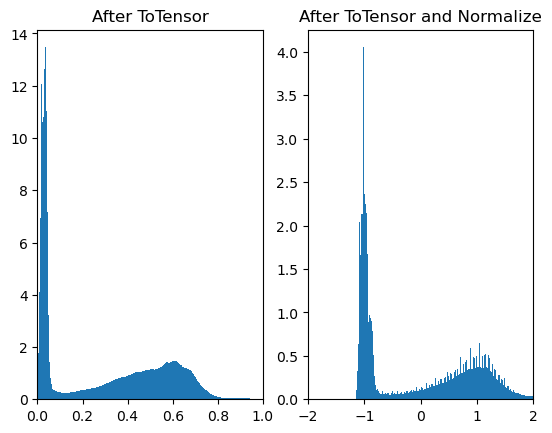

In [9]:
get_stats_on_tensor_data("./saving/stats_images.pkl", "./saving/stats_labels.pkl", classes)

In [10]:
dataset = train_dataset
dump_dataset_in_pickle(train_dataset, save_path="./saving/stats_")


Train dataset information

Number of images:	1241
Images' shape:		(256, 416, 3)
Images' dytpe:		uint8
Labels' shape:		(256, 416, 3)
Labels' dytpe:		uint8
Number of classes:	43
Mean of RGB values:	red = 84.2, green = 52.5, blue = 52.4
Median of RGB values:	red = 8.0, green = 8.0, blue = 8.0
Min of RGB values:	red = 0.0, green = 0.0, blue = 0.0
Max of RGB values:	red = 255.0, green = 255.0, blue = 255.0
Std of RGB values:	red = 64.2, green = 64.2, blue = 64.2


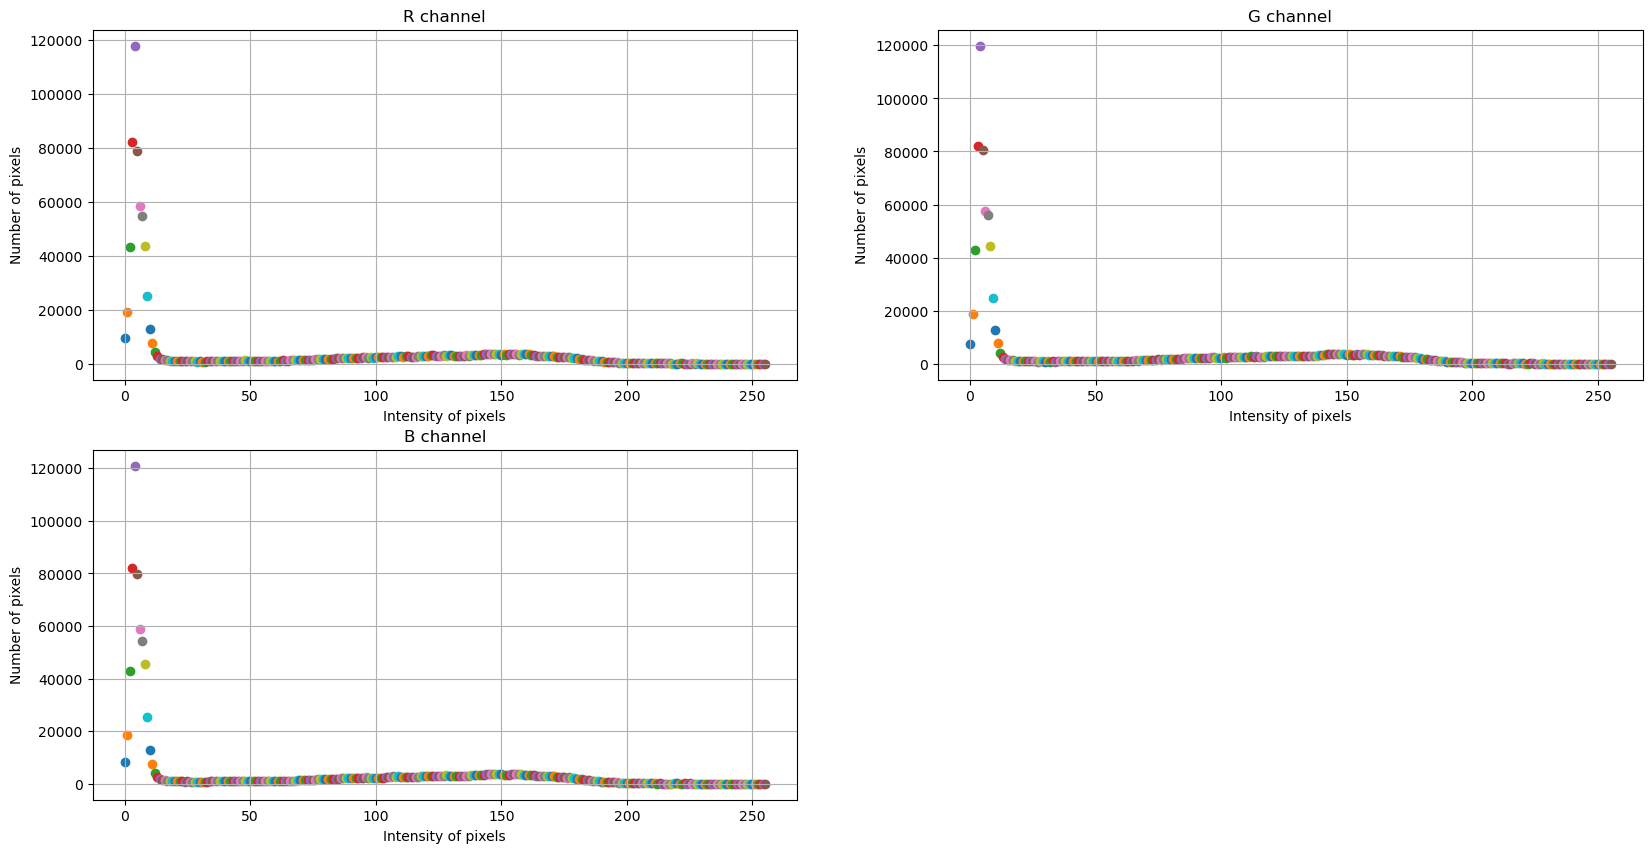

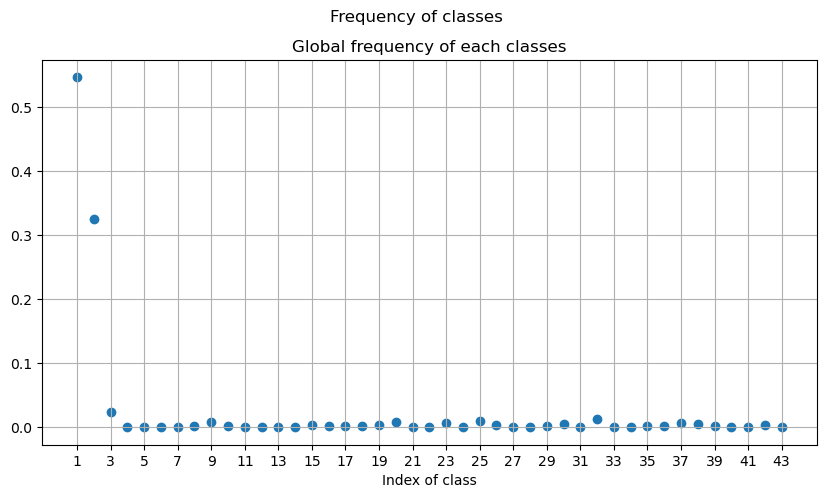

/tmp/ipykernel_27812/1553799590.py:107: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks)


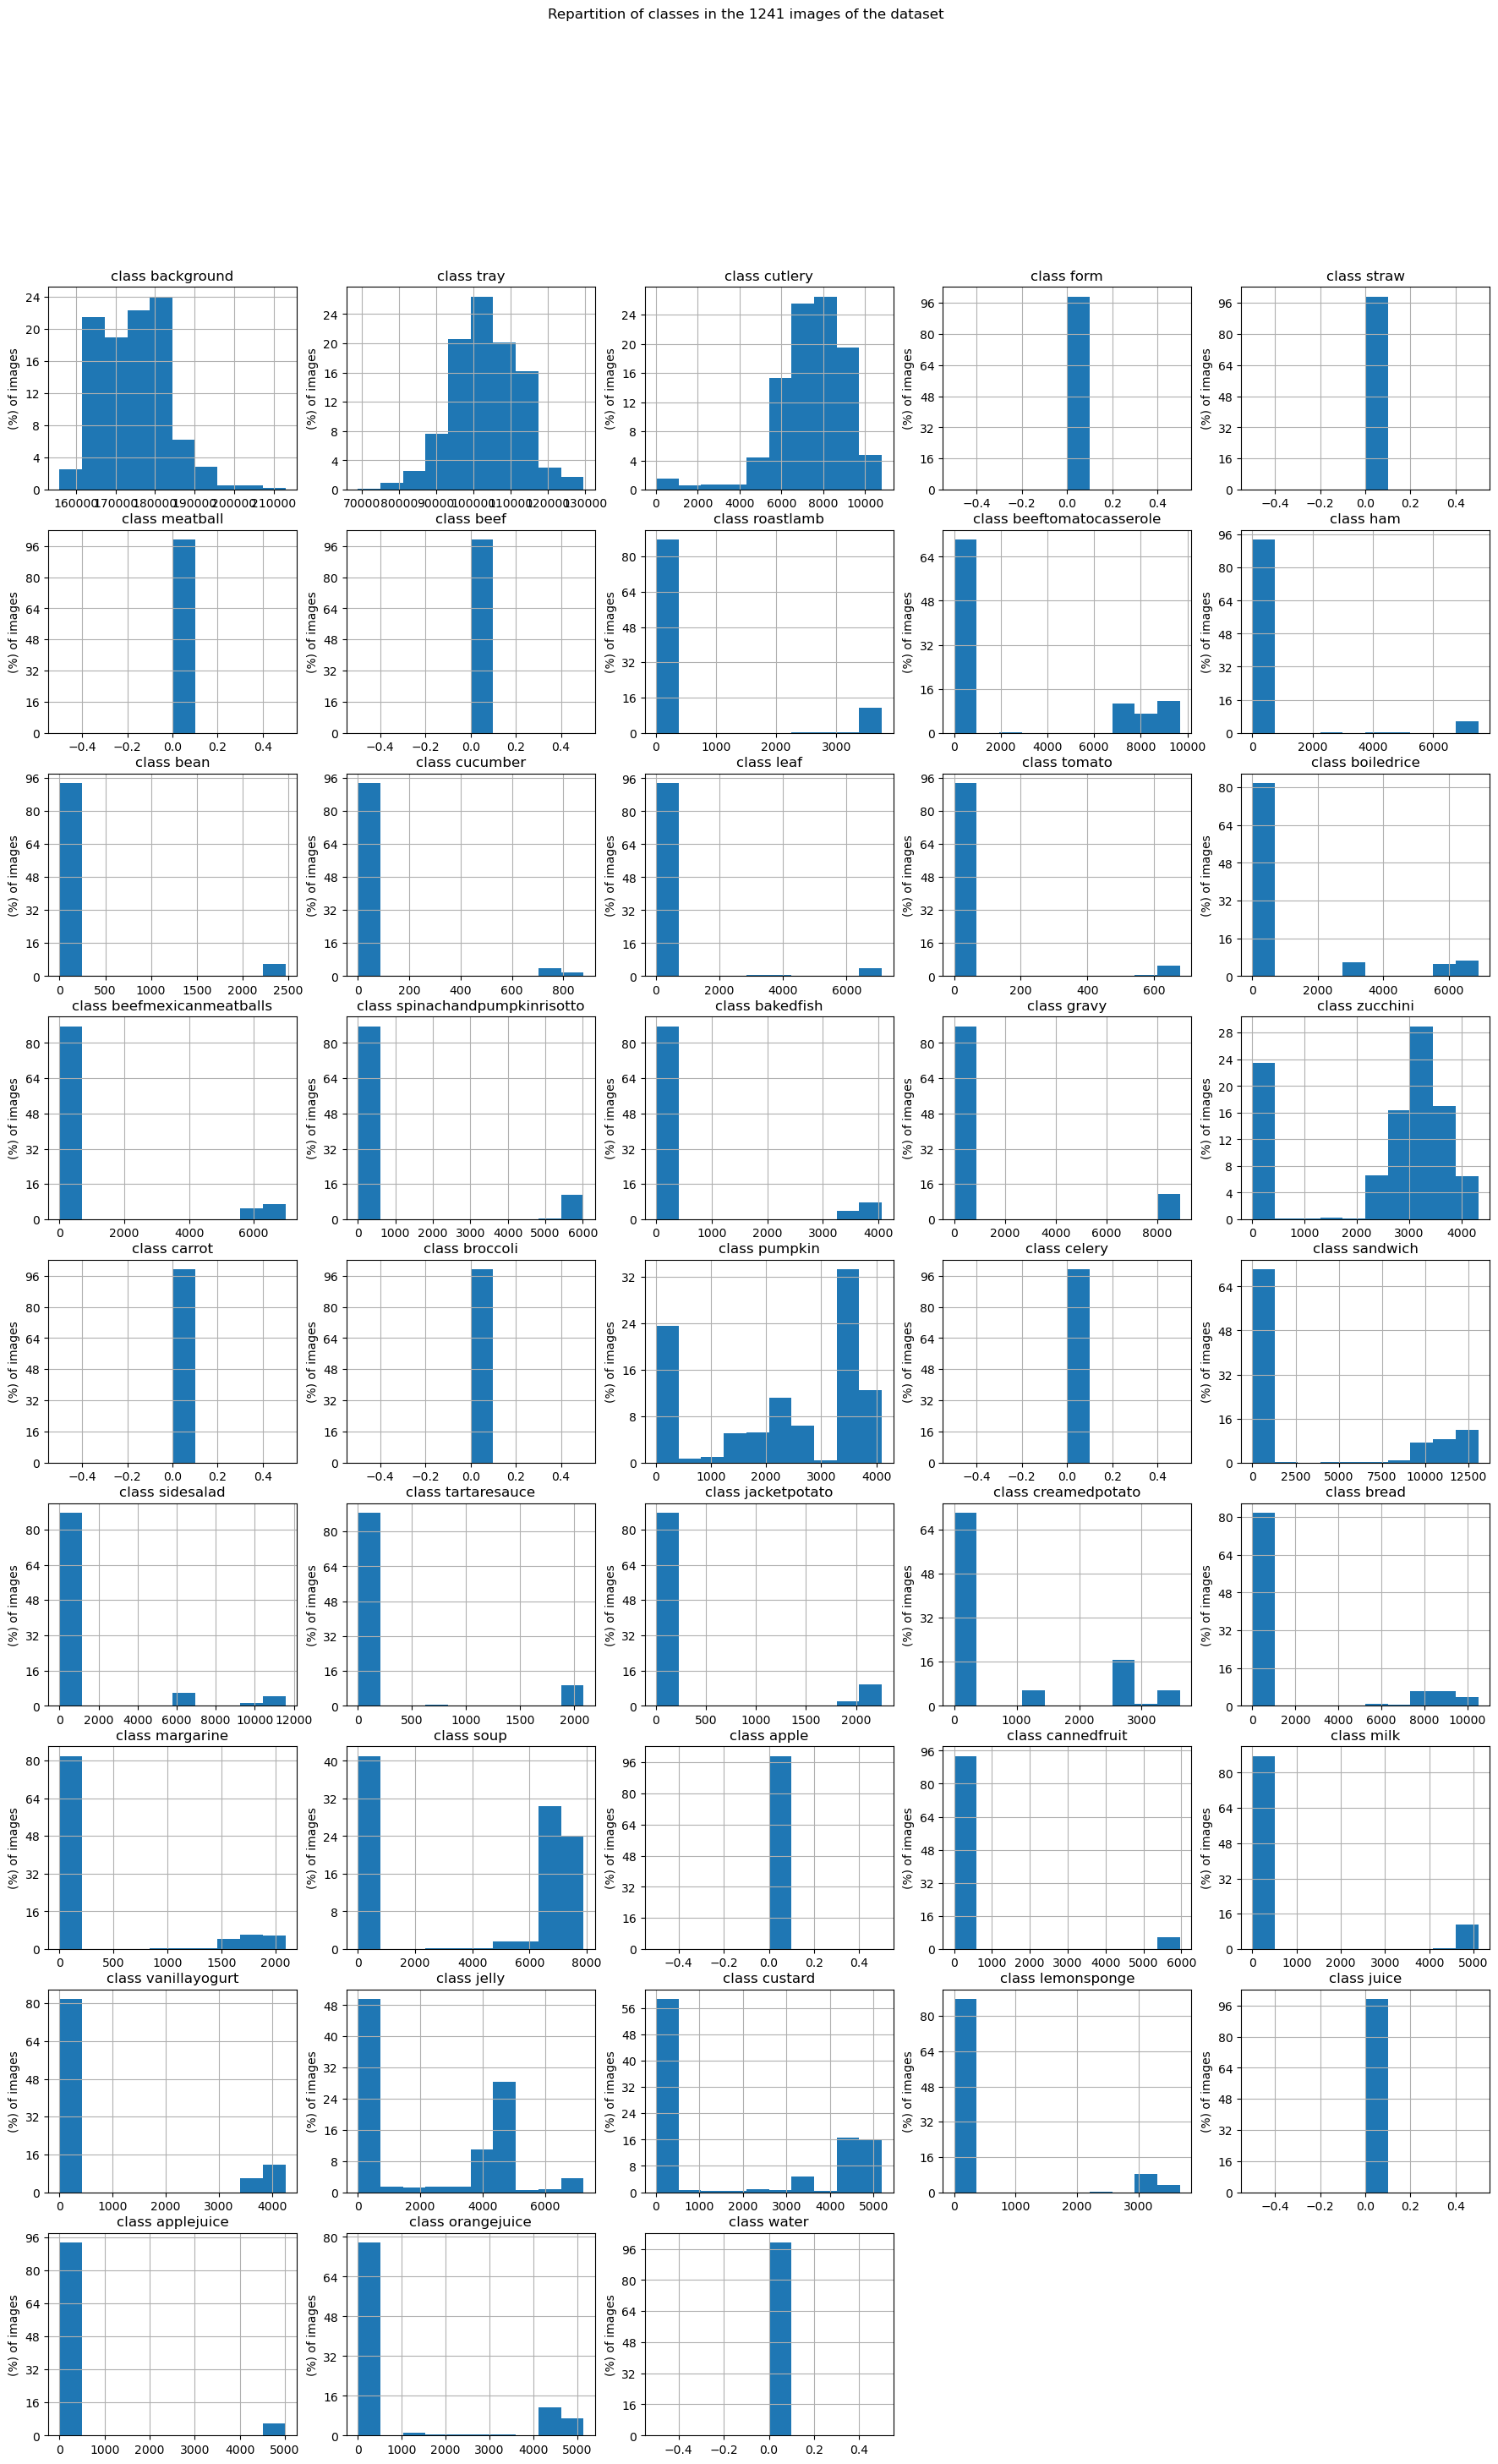

In [11]:
global_class_freq_numpy = get_stats_on_raw_numpy_data(images_pkl_path="./saving/stats_images.pkl", labels_pkl_path="./saving/stats_labels.pkl", classes=classes)

In [14]:
# create a frequency array to get the frequency of each classes and the new undetermined one
def compute_new_frequency_array(freq_array, first_class_idx_of_the_rest):
    """
        return a new frequency array containing the frequency of each classes and the new undetermined one
    """
    # rescaling the values in the range [0, 1]
    sum = np.sum(freq_array)
    freq_array = freq_array / sum

    # filling new frequency array with the computed frequencies
    new_freq_array = np.zeros(len(freq_array[:first_class_idx_of_the_rest]) + 1)
    for i in range(first_class_idx_of_the_rest):
        new_freq_array[i] += freq_array[i]
    new_freq_array[-1] += np.sum(freq_array[first_class_idx_of_the_rest:]) 

    if np.sum(new_freq_array) != 1.:
        print(f'Total sum of the new frequency array: {np.sum(new_freq_array)}')

    return new_freq_array

new_global_freq_array = compute_new_frequency_array(global_class_freq_numpy, 3)
print(new_global_freq_array)

[0.55180598 0.32753791 0.02352324 0.09713287]


### Preprocessing of the data

**Pipeline:**
> 1. function to change the classes of index to create the undetermined class
> 2. function to creates a panda dataframe that handle the new subset
> 3. transform for data augmentation
> 4. transform to convert to tensor + scaling and normalization

## Model

Our model is a basic U-Net (**REFERENCE**). We made it tunable in order to control the depth, add batch normalization or dropout on the layers and choose between two activation functions: ReLU and LeakyReLU.

In [12]:
import torch.nn as nn
import torch.nn.functional as functionnal
from torchinfo import summary

In [13]:
class Double_conv(nn.Module):

    def __init__(self, in_channels, out_channels, **kwargs):
        """
            kwargs: - batchnorm (bool), add classic 2D batchnorm
                    - dropout (bool), add dropout only if dropout_val also specified
                    - dropout_val (float), between 0 and 1 specify the dropout value on all dropout layers
                    - leaky_relu (bool), choose Leaky ReLU as activation function (alpha set by default)
        """
        super().__init__()
        self.in_channels  = in_channels
        self.out_channels = out_channels
        # layers
        self.conv_x2      = nn.Sequential()
        prev_channels     = self.in_channels

        for i in range(2):
            self.conv_x2.append(nn.Conv2d(prev_channels, self.out_channels, kernel_size=3, padding=1))

            if 'batchnorm' in kwargs and kwargs.get('batchnorm'):
                self.conv_x2.append(nn.BatchNorm2d(self.out_channels))

            if 'dropout' in kwargs and kwargs.get('dropout') and 'dropout_val' in kwargs:
                self.conv_x2.append(nn.Dropout2d(p=kwargs.get('dropout_val'), inplace=True))

            # activation
            if 'leaky_relu' in kwargs and kwargs.get('leaky_relu'):
                self.conv_x2.append(nn.LeakyReLU(inplace=True))
            else:
                self.conv_x2.append(nn.ReLU(inplace=True))

            prev_channels = self.out_channels

    def forward(self, x):
        return self.conv_x2(x)

In [14]:
class Block_down_unet(nn.Module):

    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.in_channels  = in_channels
        self.out_channels = out_channels

        self.block = nn.Sequential (
            nn.MaxPool2d(kernel_size=2, stride=2),
            Double_conv(self.in_channels, self.out_channels, **kwargs)
        )

    def forward(self, x):
        return self.block(x)

In [15]:
class Block_up_unet(nn.Module):

    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.in_channels  = in_channels
        self.out_channels = out_channels
        self.upsampling   = nn.ConvTranspose2d(self.in_channels, out_channels = self.in_channels // 2, kernel_size=2, stride=2)
        self.conv_x2      = Double_conv(self.in_channels, self.out_channels, **kwargs)

    def forward(self, x, concat_tensor):
        x = self.upsampling(x)
        # handling the shape to make shortcut path possible
        diffH = concat_tensor.size()[2] - x.size()[2]
        diffW = concat_tensor.size()[3] - x.size()[3]

        x = functionnal.pad(x, [diffW // 2, diffW - diffW // 2,
                                diffH // 2, diffH - diffH // 2])
        x_res = torch.cat([concat_tensor, x], dim=1)

        return self.conv_x2(x_res)

In [16]:
class U_Net(nn.Module):

    def __init__(self, n_in_channels, n_out_channels, depth, **kwargs):
        super().__init__()
        self.n_in_channels     = n_in_channels
        self.n_out_channels    = n_out_channels

        # model building
        self.mid_channels_list = [32 * 2**i for i in range(depth + 1)]
        self.down_part         = nn.ModuleList()
        self.up_part           = nn.ModuleList()

        # first and last layer
        self.input_layer  = Double_conv(self.n_in_channels, self.mid_channels_list[0], **kwargs)
        self.output_layer = Double_conv(self.mid_channels_list[0], self.n_out_channels, **kwargs) 

        # Encoder path
        for i in range(depth):
            self.down_part.append(
                Block_down_unet(self.mid_channels_list[i], self.mid_channels_list[i + 1], **kwargs)
            )
        # Up path
        for i in reversed(range(depth)):
            self.up_part.append(
                Block_up_unet(self.mid_channels_list[i + 1], self.mid_channels_list[i], **kwargs)
            )

    def forward(self, x):
        down_block_outputs = []
        
        # First layer
        x = self.input_layer(x)
        down_block_outputs.append(x)
        
        # Encoder path
        for i, down_layer in enumerate(self.down_part):
            x = down_layer(x)
            down_block_outputs.append(x)            
        
        # Decoder path with res path
        for i, up_layer in enumerate(self.up_part, start=1):
            x = up_layer(x, down_block_outputs[-i - 1])
        
        return self.output_layer(x)


In [17]:
unet = U_Net(n_in_channels=3, n_out_channels=4, depth=5)
summary(unet, (1, 3, 572, 572))

/home/dldou/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Layer (type:depth-idx)                        Output Shape              Param #
U_Net                                         [1, 4, 572, 572]          --
├─Double_conv: 1-1                            [1, 32, 572, 572]         --
│    └─Sequential: 2-1                        [1, 32, 572, 572]         --
│    │    └─Conv2d: 3-1                       [1, 32, 572, 572]         896
│    │    └─ReLU: 3-2                         [1, 32, 572, 572]         --
│    │    └─Conv2d: 3-3                       [1, 32, 572, 572]         9,248
│    │    └─ReLU: 3-4                         [1, 32, 572, 572]         --
├─ModuleList: 1-2                             --                        --
│    └─Block_down_unet: 2-2                   [1, 64, 286, 286]         --
│    │    └─Sequential: 3-5                   [1, 64, 286, 286]         55,424
│    └─Block_down_unet: 2-3                   [1, 128, 143, 143]        --
│    │    └─Sequential: 3-6                   [1, 128, 143, 143]        221,440
│    └─

## Trainer

In [24]:
class Trainer:

    def __init__(self, model, train_dataset, test_dataset, optimizer, loss_fn, metric_fn, device):
        
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.optimizer = optimizer
        self.criterion = loss_fn
        
        self.device = device
        
        if next(model.parameters()).device != self.device:
            self.model = model.to(self.device)
        else:
            self.model = model

        if metric_fn.device != self.device:
            self.metric = metric_fn.to(self.device)

    def get_train_dataloader(self, **kwargs) -> DataLoader:

        if self.train_dataset is None:
            raise ValueError("Trainer: training requires a train_dataset.")

        if 'batch_size' in kwargs:
            _batch_size = kwargs.get('batch_size')
        else:
            _batch_size = 32
            
        if 'shuffle' in kwargs:
            _shuffle = kwargs.get('shuffle')
        else:
            _shuffle = True

        return DataLoader(self.train_dataset, shuffle=_shuffle, batch_size=_batch_size)


    def get_test_dataloader(self, **kwargs) -> DataLoader:

        if self.train_dataset is None:
            raise ValueError("Trainer: testing requires a test_dataset.")

        if 'batch_size' in kwargs:
            _batch_size = kwargs.get('batch_size')
        else:
            _batch_size = 32
        if 'shuffle' in kwargs:
            _shuffle = kwargs.get('shuffle')
        else:
            _shuffle = True

        return DataLoader(self.test_dataset, shuffle=_shuffle, batch_size=_batch_size)


    def train_step(self, train_loader):

        running_loss = 0.0
        self.model.train()

        for data in train_loader:

                images, targets = data[0].to(self.device), data[1].to(self.device)
                #print("images", images.shape)
                #print("targets", targets.shape)
                self.optimizer.zero_grad()
                outputs = self.model(images)
                #Cropping (crop imgs are easier to process)
                crop_image = transforms.CenterCrop(outputs.size()[3])
                targets    = crop_image(targets)
                #Loss
                _, targets = torch.max(targets, dim=1)
                #print("targets", targets.shape)
                #print(targets)
                loss = self.criterion(outputs, targets)
                #Compute gradient
                loss.backward()
                #Update parameters of the model
                self.optimizer.step()
                
                running_loss += loss.item()

        return running_loss / len(train_loader)


    def test_step(self, test_loader):

        running_loss   = 0.0
        accuracy        = 0.0
        nof_predictions = 0.0

        self.model.eval()

        #Fasten the inference by setting every requires_grad to False
        with torch.no_grad():

            for data in test_loader:
                #Get data and send them to the device
                images, targets = data[0].to(self.device), data[1].to(self.device) 
                #Run the model on the test set
                outputs = self.model(images)
                #Cropping the image /!\ /!\ MUST GO /!\ /!\
                crop_image = transforms.CenterCrop(outputs.size()[3])
                targets     = crop_image(targets)
                #Compute the loss on the batch
                _, targets = torch.max(targets, dim=1)
                loss = self.criterion(outputs, targets)
                running_loss += loss.item()  
                # Compute the Jaccard Multiclass index
                _, target = torch.max(targets, dim=0)
                self.metric.update(outputs, targets)

        accuracy = self.metric.compute()

        return accuracy


    def train(self, train_loader, test_loader, nof_epochs, 
              file_path_save_model, save_epoch_path, results_file_path,
              train_loss_name, accuracy_name, test_loss_name,
              best_accuracy_is_maximal = False):
        """
            Main training entry point.
        """
        print("Starting training...\n")
        print("The model will be running on", next(self.model.parameters()).device, "device.\n")
        
        best_accuracy = 0.0
        results = []

        for epoch in range(1, nof_epochs+1):

            epoch_accuracy   = 0.0
            train_epoch_loss = 0.0
            test_epoch_loss  = 0.0

            #Training
            train_epoch_loss = self.train_step(train_loader)
            #Validation
            epoch_accuracy   = self.test_step(test_loader)
        
            print(f'Epoch: {epoch}, {train_loss_name}: {train_epoch_loss}, {test_loss_name}: {test_epoch_loss}, {accuracy_name}: {epoch_accuracy}')
            
            #Save model when best accuracy is beaten
            if best_accuracy_is_maximal:
                if epoch_accuracy > best_accuracy:
                    save_epoch_path = save_epoch_path
                    self.save_model(save_epoch_path)
                    best_accuracy = epoch_accuracy
            else:
                if epoch_accuracy < best_accuracy:
                    save_epoch_path = save_epoch_path
                    self.save_model(save_epoch_path)
                    best_accuracy = epoch_accuracy

            results.append((epoch, train_epoch_loss, epoch_accuracy))        

        # Saving the model
        print('Saving the model...\n')
        self.model = self.model.to('cpu')
        self.save_model(file_path_save_model)

        # Saving the performances
        with open(results_file_path, 'wb') as f:
            pkl.dump(results, f) 

        print("Training finish.\n") 

        return self.model


    def save_model(self, file_path):
        """
        Function to save model's parameters
        """
        torch.save(self.model.state_dict(), file_path)


    def load_model(self, file_path, load_on_GPU=True):
        """
            Function to load function when only the params have been saved
        """
        if load_on_GPU:
            params = torch.load(file_path, map_location='cuda:0')
            self.model.load_state_dict(params, map_location='cuda:0')
        else:
            params = torch.load(file_path, map_location='cpu')
            self.model.load_state_dict(params, map_location='cpu')


    def save_checkpoint(self, epoch, file_path):
        """
            Function to save model's checkpoints
        """
        torch.save({'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'loss': self.loss}, 
                    file_path)


    def load_checkpoint(self, file_path, load_on_GPU=True):
        """
            Load checkpoints
        """
        if load_on_GPU:
            checkpoint = torch.load(file_path, map_location='cuda:0')
        else:
            checkpoint = torch.load(file_path, map_location='cpu')

        #Loading
        if load_on_GPU:
            self.model.load_state_dict(checkpoint['model_state_dict'], map_location='cuda:0')
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'], map_location='cuda:0')
        else:
            self.model.load_state_dict(checkpoint['model_state_dict'], map_location='cpu')
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'], map_location='cpu')
        
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']

        return epoch, loss
        

## Utils

In [25]:
import matplotlib.pyplot as plt
import random

In [26]:
def plot_results(model, test_loader):
    """
    Display few images and segmentations
    """

    fig, axs = plt.subplots(3,3,figsize=(12,12))

    #Display 4*4=16 images
    for row_idx in range(3):

        #Select a random image in the dataset
        nof_images = len(test_loader.dataset)
        idx = random.randrange(nof_images)

        for data in test_loader:

            #Inference
            image, target = data[0].to('cuda:0'), data[1].to('cuda:0')
            model.eval()

            with torch.no_grad():
                output = model(image)

            break

        #Sent back the image to the CPU + layout
        image     = image[0,:,:,:].permute(1,2,0).to('cpu').numpy() + 0.5
        target    = target[0,:,:,:].permute(1,2,0).to('cpu').numpy()
        # Getting all classes on 1 image
        output    = output[0,:,:,:].permute(1,2,0).to('cpu')
        _, output = torch.max(output, dim=2)
        output    = output.numpy()

        #Plot
        axs[row_idx, 0].imshow(image, vmin=-1, vmax=1)
        axs[row_idx, 0].set_title("Image")
        axs[row_idx, 0].axis('off')

        axs[row_idx, 1].imshow(target, cmap='gray', vmin=0, vmax=42)
        axs[row_idx, 1].set_title("Ground truth segmentation")
        axs[row_idx, 1].axis('off')


        axs[row_idx, 2].imshow(output, cmap='gray', vmin=0, vmax=1)
        axs[row_idx, 2].set_title("Net segmentation")
        axs[row_idx, 2].axis('off')
    
    fig.suptitle("{} on few examples\n Reached accuracy with 3 epochs: {}%".format(model.__class__.__name__, 0.02325))

    #Save
    plt.savefig(str(model.__class__.__name__) + "_accuraccy_0.02325" + ".pdf")

    #Show
    plt.show()


def plot_model_performances(file_path, 
                            model_name, optimizer_name, loss_name, 
                            learning_rate, 
                            save=True):

    results = pkl.load(open(file_path, 'rb'))
    
    fig, (ax0, ax1) = plt.subplots(1,2, sharex=True, figsize=(15,5))

    l_train_epoch_loss = list()
    l_epoch_accuracy   = list()

    for epoch, train_epoch_loss, epoch_accuracy in results:
        l_train_epoch_loss.append(train_epoch_loss)
        l_epoch_accuracy.append(epoch_accuracy.to('cpu'))

    ax0.set_title("Evolution of the loss")
    ax0.plot([i+1 for i in range(len(l_train_epoch_loss))], l_train_epoch_loss)
    ax0.set_xticks([i+1 for i in range(len(l_train_epoch_loss))])
    ax0.set_xlabel("Epoch index")
    ax0.set_ylabel("Loss")
    ax0.grid()
    
    ax1.set_title("Evolution of the accuracy")
    ax1.plot([i+1 for i in range(len(l_epoch_accuracy))], l_epoch_accuracy)
    ax1.set_xticks([i+1 for i in range(len(l_epoch_accuracy))])
    ax1.set_xlabel("Epoch index")
    ax1.set_ylabel("Accuracy")
    ax1.grid()

    suptitle = "Performances of " + model_name + " with " + "optimizer " + optimizer_name + " (lr=" + str(learning_rate) + ")" + ", " + "loss " + loss_name 
    fig.suptitle(suptitle)

    if save:
        plt.savefig(suptitle + ".pdf")

    plt.show()


## Main

In [27]:
from torchsummary import summary
from torchmetrics import JaccardIndex

In [28]:
if __name__ == "__main__":


    ### Data
    transform        = transforms.Compose([transforms.Pad((78,158), fill=0, padding_mode='constant'),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=0.5, std=0.5)])
    
    target_transform = transforms.Compose([transforms.Pad((78,158), fill=0, padding_mode='constant')])

    annotations_file_path    = '/home/dldou/Projets_ML/Unet/classes.csv'
    train_dataset_img_path   = '/home/dldou/Projets_ML/Unet/TrayDataset/TrayDataset/XTrain/'
    train_dataset_label_path = '/home/dldou/Projets_ML/Unet/TrayDataset/TrayDataset/yTrain/'
  
    train_dataset            = TrayDataset(annotations_file_path, 
                                           train_dataset_img_path, train_dataset_label_path,
                                           transform, target_transform
                                           )

    test_dataset_img_path   = '/home/dldou/Projets_ML/Unet/TrayDataset/TrayDataset/XTest/'
    test_dataset_label_path = '/home/dldou/Projets_ML/Unet/TrayDataset/TrayDataset/yTest/'    

    test_dataset            = TrayDataset(annotations_file_path, 
                                           test_dataset_img_path, test_dataset_label_path,
                                           transform, target_transform
                                           )
    

    ### Model 
    in_channels = 3 
    n_classes = len(train_dataset.labels) 
    Unet = UNet(in_channels, n_classes)
    #summary(Unet, (3, 572, 572))

    ### Trainer 
    # Hyper-params
    lr          = 1e-4
    _batch_size = 2
    n_epochs    = 3

    # Other params
    model = Unet
    optimizer = torch.optim.Adam(model.parameters(), lr)
    loss_fn = nn.CrossEntropyLoss()
    metric_fn = met.JaccardIndex(task="multiclass", num_classes=n_classes)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    trainer = Trainer(model, train_dataset, test_dataset, optimizer, loss_fn, metric_fn, device)

    # Dataloader
    train_dataloader = trainer.get_train_dataloader(shuffle=True, batch_size=_batch_size)
    test_dataloader  = trainer.get_test_dataloader(shuffle=True, batch_size=_batch_size)

    # Training
    file_path_save_model = "./saving/trained_Unet_model.pth"
    save_epoch_path = "./saving/trained_Unet_model_best_accuracy.pth"    
    results_file_path = "results.pkl"
    train_loss_name = "Cross Entropy Loss 2D"
    accuracy_name = "Jaccard score"
    test_loss_name = train_loss_name
    best_accuracy_is_maximal = True

    trainer.train(train_dataloader, test_dataloader, n_epochs, 
                  file_path_save_model, save_epoch_path, results_file_path,
                  train_loss_name, accuracy_name, test_loss_name,
                  best_accuracy_is_maximal)
    

    ### Inferences and performances
    #plot_results(Unet, test_dataloader, device)



Starting training...

The model will be running on cuda:0 device.



KeyboardInterrupt: 

## Performances

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


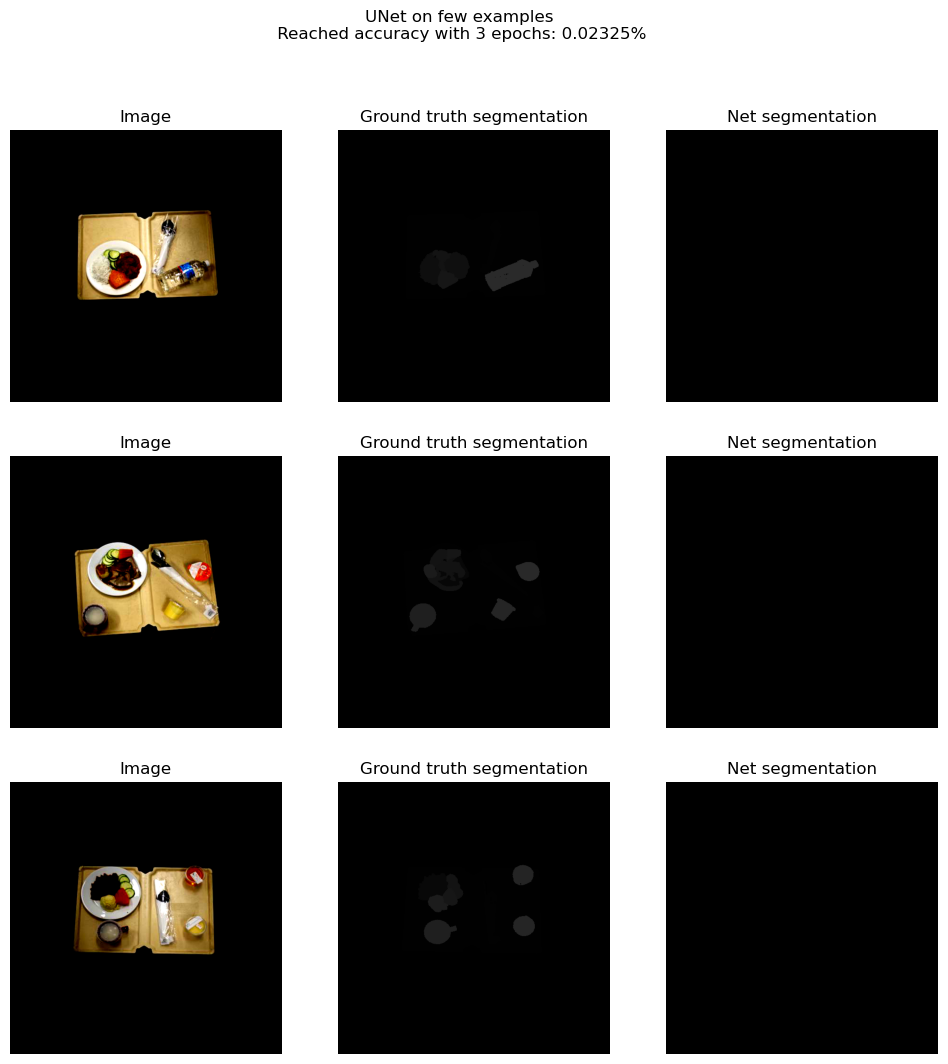

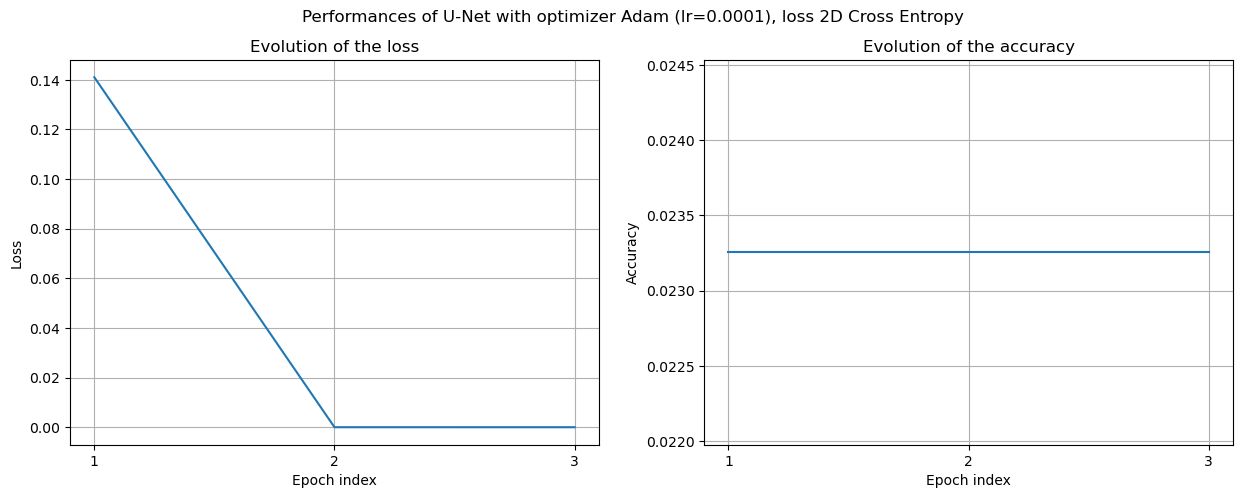

In [ ]:
model = trainer.model.to('cuda:0')
plot_results(model, test_dataloader)

file_path      = "results.pkl"
model_name     = "U-Net"
optimizer_name = "Adam"
loss_name      = "2D Cross Entropy"
learning_rate  = 1e-4
save           = True
plot_model_performances(file_path, 
                        model_name, optimizer_name, loss_name, 
                        learning_rate, 
                        save=True)

## Conclusion

As we can see, our model assigns the background class to all pixels after only one epoch. This is due to the 2D cross entropy cost function which isn't adapted to a dataset where the classes are unbalanced. We'll try the Focal Cross Entropy Loss.